In [68]:
# Core Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.cm as cm
import random

#Misspelling algorithm
import csv
from collections import defaultdict
import Levenshtein
import os

# Bipartite graph
from collections import Counter
from scipy import stats

# 1. Network Source

**Primary source**: Marvel characters and comics [dataset](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network)

**Data components**: 
- `nodes.csv`: Contains node identifiers and types (hero or comic)
- `edges.csv`: Contains hero-comic relationships (which heroes appear in which comics)
- `hero-edge.csv`: Contains the network of heroes that appear together

# 2. Data Loading

In [3]:
# Load the datasets
nodes_df = pd.read_csv('Data/nodes.csv')
edges_df = pd.read_csv('Data/edges.csv')
hero_network_df = pd.read_csv('Data/hero-network.csv')

# Display the first few rows of each dataset
print("Nodes DataFrame:")
display(nodes_df.head())
print("\nEdges DataFrame:")
display(edges_df.head())
print("\nHero Network DataFrame:")
display(hero_network_df.head())

Nodes DataFrame:


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero



Edges DataFrame:


,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251



Hero Network DataFrame:


,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


# 3. Data Quality and Preprocessing

## 3.1. Quality check 

### 3.1.1 Misspelling mistakes

This script analyzes hero names across three DataFrames (edges_df, hero_network_df, and nodes_df) to identify potential spelling inconsistencies in hero names.

In [5]:
# Configuration
SIMILARITY_THRESHOLD = 0.8  # Minimum similarity to consider (0-1)
MIN_NAME_LENGTH = 4  # Minimum name length to compare
OUTPUT_FILE = 'hero_spelling_results2.csv'  # Output file name
RESULT_LIMIT = None  # Limit number of results (None for all)

In [6]:
def load_hero_names_from_dataframes(edges_df, hero_network_df, nodes_df):
    """
    Load hero names from all three DataFrames and track their sources.
    
    Returns:
        dict: A dictionary with hero names as keys and a dict of sources as values
    """
    hero_sources = defaultdict(lambda: {'edges': False, 'heronetwork': False, 'nodes': False})
    
    # Load from edges_df
    try:
        for hero in edges_df['hero'].unique():
            hero_sources[hero]['edges'] = True
        print(f"Loaded {len(edges_df['hero'].unique())} unique heroes from edges DataFrame")
    except Exception as e:
        print(f"Error processing edges DataFrame: {e}")
    
    # Load from hero_network_df
    try:
        for hero in hero_network_df['hero1'].unique():
            hero_sources[hero]['heronetwork'] = True
        for hero in hero_network_df['hero2'].unique():
            hero_sources[hero]['heronetwork'] = True
        print(f"Loaded {len(set(hero_network_df['hero1']).union(set(hero_network_df['hero2'])))} unique heroes from hero_network DataFrame")
    except Exception as e:
        print(f"Error processing hero_network DataFrame: {e}")
    
    # Load from nodes_df
    try:
        hero_nodes = nodes_df[nodes_df['type'] == 'hero']
        for hero in hero_nodes['node'].unique():
            hero_sources[hero]['nodes'] = True
        print(f"Loaded {len(hero_nodes['node'].unique())} unique heroes from nodes DataFrame")
    except Exception as e:
        print(f"Error processing nodes DataFrame: {e}")
    
    print(f"Total unique hero names across all DataFrames: {len(hero_sources)}")
    return hero_sources


def calculate_similarity(str1, str2):
    """
    Calculate string similarity based on Levenshtein distance.
    
    Returns:
        float: Similarity score between 0 and 1
    """
    distance = Levenshtein.distance(str1.lower(), str2.lower())
    max_len = max(len(str1), len(str2))
    return 1 - (distance / max_len) if max_len > 0 else 1


def find_similar_names(hero_sources, threshold=0.8, min_length=4):
    """
    Find hero names that are similar but not identical.
    
    Args:
        hero_sources: Dictionary of hero names and their sources
        threshold: Minimum similarity score to consider (default: 0.8)
        min_length: Minimum length of names to compare (default: 4)
        
    Returns:
        list: List of dictionaries with similar name pairs and their info
    """
    similar_pairs = []
    processed_pairs = set()
    heroes = list(hero_sources.keys())
    
    # Sort heroes by length for optimization
    heroes.sort(key=len)
    
    print(f"Finding similar names (threshold: {threshold}, min length: {min_length})...")
    total = len(heroes)
    
    for i, hero1 in enumerate(heroes):
        if len(hero1) < min_length:
            continue
            
        if i % 100 == 0:
            print(f"Progress: {i}/{total} heroes processed...")
            
        for hero2 in heroes[i+1:]:
            # Skip if second hero is much longer (optimization)
            if len(hero2) > len(hero1) * 1.5:
                break
                
            # Skip very short names
            if len(hero2) < min_length:
                continue
                
            # Check if we've processed this pair
            pair_key = '|'.join(sorted([hero1, hero2]))
            if pair_key in processed_pairs:
                continue
            processed_pairs.add(pair_key)
            
            # Calculate similarity
            similarity = calculate_similarity(hero1, hero2)
            
            # If similarity is above threshold and names are not identical
            if similarity >= threshold and similarity < 1:
                similar_pairs.append({
                    'hero1': hero1,
                    'hero2': hero2,
                    'similarity': similarity,
                    'sources1': hero_sources[hero1],
                    'sources2': hero_sources[hero2]
                })
    
    # Sort by similarity (highest first)
    similar_pairs.sort(key=lambda x: x['similarity'], reverse=True)
    return similar_pairs


def format_source_info(sources):
    """Format source information for display"""
    source_list = []
    if sources['edges']:
        source_list.append('edges_df')
    if sources['heronetwork']:
        source_list.append('hero_network_df')
    if sources['nodes']:
        source_list.append('nodes_df')
    return ', '.join(source_list)


def export_results(similar_pairs, output_file):
    """Export results to a CSV file"""
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Hero Name 1', 'Hero Name 2', 'Similarity (%)', 'Sources for Hero 1', 'Sources for Hero 2'])
        
        for pair in similar_pairs:
            writer.writerow([
                pair['hero1'], 
                pair['hero2'],
                f"{pair['similarity'] * 100:.1f}",
                format_source_info(pair['sources1']),
                format_source_info(pair['sources2'])
            ])
    
    print(f"Results exported to {output_file}")


# Run the analysis with existing DataFrames
def run_analysis_with_dfs(edges_df, hero_network_df, nodes_df):
    print("Loading hero names from DataFrames...")
    hero_sources = load_hero_names_from_dataframes(edges_df, hero_network_df, nodes_df)
    
    similar_pairs = find_similar_names(
        hero_sources, 
        threshold=SIMILARITY_THRESHOLD,
        min_length=MIN_NAME_LENGTH
    )
    
    if RESULT_LIMIT:
        similar_pairs = similar_pairs[:RESULT_LIMIT]
    
    print(f"Found {len(similar_pairs)} potential spelling inconsistencies")
    
    # Print top 10 results
    print("\nTop potential inconsistencies:")
    for i, pair in enumerate(similar_pairs[:10]):
        print(f"{i+1}. {pair['hero1']} <-> {pair['hero2']} ({pair['similarity']:.3f})")
        print(f"   Sources for {pair['hero1']}: {format_source_info(pair['sources1'])}")
        print(f"   Sources for {pair['hero2']}: {format_source_info(pair['sources2'])}")
        print()
    
    export_results(similar_pairs, OUTPUT_FILE)
    return similar_pairs


In [7]:

similar_pairs = run_analysis_with_dfs(edges_df, hero_network_df, nodes_df)
results_df = pd.DataFrame(similar_pairs)
results_df.head()

Loading hero names from DataFrames...
Loaded 6439 unique heroes from edges DataFrame
Loaded 6426 unique heroes from hero_network DataFrame
Loaded 6439 unique heroes from nodes DataFrame
Total unique hero names across all DataFrames: 6584
Finding similar names (threshold: 0.8, min length: 4)...
Progress: 100/6584 heroes processed...
Progress: 200/6584 heroes processed...
Progress: 300/6584 heroes processed...
Progress: 400/6584 heroes processed...
Progress: 500/6584 heroes processed...
Progress: 600/6584 heroes processed...
Progress: 700/6584 heroes processed...
Progress: 800/6584 heroes processed...
Progress: 900/6584 heroes processed...
Progress: 1000/6584 heroes processed...
Progress: 1100/6584 heroes processed...
Progress: 1200/6584 heroes processed...
Progress: 1300/6584 heroes processed...
Progress: 1400/6584 heroes processed...
Progress: 1500/6584 heroes processed...
Progress: 1600/6584 heroes processed...
Progress: 1700/6584 heroes processed...
Progress: 1800/6584 heroes process

,hero1,hero2,similarity,sources1,sources2
0,AGAMEMNON II/ANDREI,AGAMEMNON II/ANDREI,0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."
1,ANDROMEDA/ANDROMEDA,ANDROMEDA/ANDROMEDA,0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."
2,"ANGELOPOULOS, ANGEL","ANGELOPOULOS, ANGEL",0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."
3,APE MAN/GORDON MONK,APE MAN/GORDON MONK,0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."
4,APOCALYPSE/EN SABAH,APOCALYPSE/EN SABAH,0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."


In [ ]:
#!/usr/bin/env python3
"""
Hero Name Spelling Consistency Checker (Jupyter Notebook Version)

This script analyzes three CSV files (edges.csv, heronetwork.csv, and nodes.csv)
to identify potential spelling inconsistencies in hero names across the files.
"""

# Set your file paths here
EDGES_FILE = 'Data/edges.csv'  # MODIFY THIS PATH
HERONETWORK_FILE = 'Data/hero-network.csv'  # MODIFY THIS PATH
NODES_FILE = 'Data/nodes.csv'  # MODIFY THIS PATH

# Configuration
SIMILARITY_THRESHOLD = 0.8  # Minimum similarity to consider (0-1)
MIN_NAME_LENGTH = 4  # Minimum name length to compare
OUTPUT_FILE = 'hero_spelling_results.csv'  # Output file name
RESULT_LIMIT = None  # Limit number of results (None for all)


def load_hero_names(edges_file, heronetwork_file, nodes_file):
    """
    Load hero names from all three CSV files and track their sources.
    
    Returns:
        dict: A dictionary with hero names as keys and a dict of sources as values
    """
    hero_sources = defaultdict(lambda: {'edges': False, 'heronetwork': False, 'nodes': False})
    
    # Load from edges.csv
    try:
        edges_df = pd.read_csv(edges_file)
        for hero in edges_df['hero'].unique():
            hero_sources[hero]['edges'] = True
        print(f"Loaded {len(edges_df['hero'].unique())} unique heroes from edges.csv")
    except Exception as e:
        print(f"Error loading edges.csv: {e}")
    
    # Load from heronetwork.csv
    try:
        heronet_df = pd.read_csv(heronetwork_file)
        for hero in heronet_df['hero1'].unique():
            hero_sources[hero]['heronetwork'] = True
        for hero in heronet_df['hero2'].unique():
            hero_sources[hero]['heronetwork'] = True
        print(f"Loaded {len(set(heronet_df['hero1']).union(set(heronet_df['hero2'])))} unique heroes from heronetwork.csv")
    except Exception as e:
        print(f"Error loading heronetwork.csv: {e}")
    
    # Load from nodes.csv
    try:
        nodes_df = pd.read_csv(nodes_file)
        hero_nodes = nodes_df[nodes_df['type'] == 'hero']
        for hero in hero_nodes['node'].unique():
            hero_sources[hero]['nodes'] = True
        print(f"Loaded {len(hero_nodes['node'].unique())} unique heroes from nodes.csv")
    except Exception as e:
        print(f"Error loading nodes.csv: {e}")
    
    print(f"Total unique hero names across all files: {len(hero_sources)}")
    return hero_sources


def calculate_similarity(str1, str2):
    """
    Calculate string similarity based on Levenshtein distance.
    
    Returns:
        float: Similarity score between 0 and 1
    """
    distance = Levenshtein.distance(str1.lower(), str2.lower())
    max_len = max(len(str1), len(str2))
    return 1 - (distance / max_len) if max_len > 0 else 1


def find_similar_names(hero_sources, threshold=0.8, min_length=4):
    """
    Find hero names that are similar but not identical.
    
    Args:
        hero_sources: Dictionary of hero names and their sources
        threshold: Minimum similarity score to consider (default: 0.8)
        min_length: Minimum length of names to compare (default: 4)
        
    Returns:
        list: List of dictionaries with similar name pairs and their info
    """
    similar_pairs = []
    processed_pairs = set()
    heroes = list(hero_sources.keys())
    
    # Sort heroes by length for optimization
    heroes.sort(key=len)
    
    print(f"Finding similar names (threshold: {threshold}, min length: {min_length})...")
    total = len(heroes)
    
    for i, hero1 in enumerate(heroes):
        if len(hero1) < min_length:
            continue
            
        if i % 100 == 0:
            print(f"Progress: {i}/{total} heroes processed...")
            
        for hero2 in heroes[i+1:]:
            # Skip if second hero is much longer (optimization)
            if len(hero2) > len(hero1) * 1.5:
                break
                
            # Skip very short names
            if len(hero2) < min_length:
                continue
                
            # Check if we've processed this pair
            pair_key = '|'.join(sorted([hero1, hero2]))
            if pair_key in processed_pairs:
                continue
            processed_pairs.add(pair_key)
            
            # Calculate similarity
            similarity = calculate_similarity(hero1, hero2)
            
            # If similarity is above threshold and names are not identical
            if similarity >= threshold and similarity < 1:
                similar_pairs.append({
                    'hero1': hero1,
                    'hero2': hero2,
                    'similarity': similarity,
                    'sources1': hero_sources[hero1],
                    'sources2': hero_sources[hero2]
                })
    
    # Sort by similarity (highest first)
    similar_pairs.sort(key=lambda x: x['similarity'], reverse=True)
    return similar_pairs


def format_source_info(sources):
    """Format source information for display"""
    source_list = []
    if sources['edges']:
        source_list.append('edges.csv')
    if sources['heronetwork']:
        source_list.append('heronetwork.csv')
    if sources['nodes']:
        source_list.append('nodes.csv')
    return ', '.join(source_list)


def export_results(similar_pairs, output_file):
    """Export results to a CSV file"""
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Hero Name 1', 'Hero Name 2', 'Similarity (%)', 'Sources for Hero 1', 'Sources for Hero 2'])
        
        for pair in similar_pairs:
            writer.writerow([
                pair['hero1'], 
                pair['hero2'],
                f"{pair['similarity'] * 100:.1f}",
                format_source_info(pair['sources1']),
                format_source_info(pair['sources2'])
            ])
    
    print(f"Results exported to {output_file}")


# Run the script (this will execute when you run the cell)
def run_analysis():
    print("Loading hero names from CSV files...")
    hero_sources = load_hero_names(EDGES_FILE, HERONETWORK_FILE, NODES_FILE)
    
    similar_pairs = find_similar_names(
        hero_sources, 
        threshold=SIMILARITY_THRESHOLD,
        min_length=MIN_NAME_LENGTH
    )
    
    if RESULT_LIMIT:
        similar_pairs = similar_pairs[:RESULT_LIMIT]
    
    print(f"Found {len(similar_pairs)} potential spelling inconsistencies")
    
    # Print top 10 results
    print("\nTop potential inconsistencies:")
    for i, pair in enumerate(similar_pairs[:10]):
        print(f"{i+1}. {pair['hero1']} <-> {pair['hero2']} ({pair['similarity']:.3f})")
        print(f"   Sources for {pair['hero1']}: {format_source_info(pair['sources1'])}")
        print(f"   Sources for {pair['hero2']}: {format_source_info(pair['sources2'])}")
        print()
    
    export_results(similar_pairs, OUTPUT_FILE)
    return similar_pairs

# Execute the analysis
similar_pairs = run_analysis()

# You can also analyze the results further in the notebook
# For example:
# import pandas as pd
results_df = pd.DataFrame(similar_pairs)
results_df.head()

Loading hero names from CSV files...
Loaded 6439 unique heroes from edges.csv
Loaded 6426 unique heroes from heronetwork.csv
Loaded 6439 unique heroes from nodes.csv
Total unique hero names across all files: 6584
Finding similar names (threshold: 0.8, min length: 4)...
Progress: 100/6584 heroes processed...
Progress: 200/6584 heroes processed...
Progress: 300/6584 heroes processed...
Progress: 400/6584 heroes processed...
Progress: 500/6584 heroes processed...
Progress: 600/6584 heroes processed...
Progress: 700/6584 heroes processed...
Progress: 800/6584 heroes processed...
Progress: 900/6584 heroes processed...
Progress: 1000/6584 heroes processed...
Progress: 1100/6584 heroes processed...
Progress: 1200/6584 heroes processed...
Progress: 1300/6584 heroes processed...
Progress: 1400/6584 heroes processed...
Progress: 1500/6584 heroes processed...
Progress: 1600/6584 heroes processed...
Progress: 1700/6584 heroes processed...
Progress: 1800/6584 heroes processed...
Progress: 1900/6584

,hero1,hero2,similarity,sources1,sources2
0,AGAMEMNON II/ANDREI,AGAMEMNON II/ANDREI,0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."
1,ANDROMEDA/ANDROMEDA,ANDROMEDA/ANDROMEDA,0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."
2,"ANGELOPOULOS, ANGEL","ANGELOPOULOS, ANGEL",0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."
3,APE MAN/GORDON MONK,APE MAN/GORDON MONK,0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."
4,APOCALYPSE/EN SABAH,APOCALYPSE/EN SABAH,0.95,"{'edges': True, 'heronetwork': False, 'nodes':...","{'edges': False, 'heronetwork': True, 'nodes':..."


The majority of spelling mistakes were due to trailing spaces from the hero-network df. We use the following script to remove them. 

In [34]:
# Remove the space after at the end of the name
#!/usr/bin/env python3
"""
Remove trailing spaces from hero names in the hero-network_corr.csv file.

This script reads the hero-network_corr.csv file, removes any trailing spaces
from hero names in both columns, and writes the result to a new file.
"""

import pandas as pd
import os

# Input and output file paths
INPUT_FILE = 'Data/hero-network_corr.csv'
OUTPUT_FILE = 'Data/hero-network_corr_cleaned.csv'

def clean_trailing_spaces():
    print(f"Reading file: {INPUT_FILE}")
    
    try:
        # Read the CSV file
        df = pd.read_csv(INPUT_FILE)
        
        # Show original column names and first few rows
        print("\nOriginal data sample:")
        print(df.head())
        
        # Get total row count
        original_rows = len(df)
        print(f"\nTotal rows in original file: {original_rows}")
        
        # Identify column names (they might vary)
        columns = df.columns.tolist()
        if len(columns) != 2:
            print(f"Warning: Expected 2 columns, found {len(columns)}: {columns}")
        
        hero1_col = columns[0]  # Typically 'hero1'
        hero2_col = columns[1]  # Typically 'hero2'
        
        # Check for trailing spaces before cleaning
        hero1_trailing_spaces = df[df[hero1_col].str.endswith(' ', na=False)].shape[0]
        hero2_trailing_spaces = df[df[hero2_col].str.endswith(' ', na=False)].shape[0]
        
        print(f"\nBefore cleaning:")
        print(f"- Names with trailing spaces in {hero1_col}: {hero1_trailing_spaces}")
        print(f"- Names with trailing spaces in {hero2_col}: {hero2_trailing_spaces}")
        
        # Sample of entries with trailing spaces (for verification)
        if hero1_trailing_spaces > 0:
            print("\nSample entries with trailing spaces in first column:")
            trailing_samples = df[df[hero1_col].str.endswith(' ', na=False)].head(5)
            for _, row in trailing_samples.iterrows():
                print(f"'{row[hero1_col]}' -> '{row[hero1_col].rstrip()}'")
                
        # Apply the string strip function to remove trailing spaces
        df[hero1_col] = df[hero1_col].str.rstrip()
        df[hero2_col] = df[hero2_col].str.rstrip()
        
        # Verify cleaning worked
        hero1_trailing_spaces_after = df[df[hero1_col].str.endswith(' ', na=False)].shape[0]
        hero2_trailing_spaces_after = df[df[hero2_col].str.endswith(' ', na=False)].shape[0]
        
        print(f"\nAfter cleaning:")
        print(f"- Names with trailing spaces in {hero1_col}: {hero1_trailing_spaces_after}")
        print(f"- Names with trailing spaces in {hero2_col}: {hero2_trailing_spaces_after}")
        
        # Write the cleaned data to a new CSV file
        df.to_csv(OUTPUT_FILE, index=False)
        print(f"\nCleaned data written to: {OUTPUT_FILE}")
        
        # Suggestion for next steps
        print("\nTo verify the cleaning worked correctly, you can:")
        print(f"1. Check that '{OUTPUT_FILE}' exists and has {len(df)} rows")
        print("2. Open the file and verify no hero names have trailing spaces")
        print(f"3. If everything looks good, you can replace the original file with:")
        print(f"   import shutil; shutil.move('{OUTPUT_FILE}', '{INPUT_FILE}')")
        
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    clean_trailing_spaces()

Reading file: Data/hero-network_corr.csv

Original data sample:
                  hero1                 hero2
0         LITTLE, ABNER        PRINCESS ZANDA
1         LITTLE, ABNER  BLACK PANTHER/T'CHAL
2  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3         LITTLE, ABNER        PRINCESS ZANDA
4         LITTLE, ABNER  BLACK PANTHER/T'CHAL

Total rows in original file: 574467

Before cleaning:
- Names with trailing spaces in hero1: 75735
- Names with trailing spaces in hero2: 73556

Sample entries with trailing spaces in first column:
'IRON MAN/TONY STARK ' -> 'IRON MAN/TONY STARK'
'IRON MAN/TONY STARK ' -> 'IRON MAN/TONY STARK'
'STARSHINE II/BRANDY ' -> 'STARSHINE II/BRANDY'
'STARSHINE II/BRANDY ' -> 'STARSHINE II/BRANDY'
'STARSHINE II/BRANDY ' -> 'STARSHINE II/BRANDY'

After cleaning:
- Names with trailing spaces in hero1: 0
- Names with trailing spaces in hero2: 0

Cleaned data written to: Data/hero-network_corr_cleaned.csv

To verify the cleaning worked correctly, you can:
1. Check t

After a torough manual inspection of the outputed `hero_spelling_results.csv`, we have corrected the spelling mistakes in our datasets and renamed the corrected files as: 
- `edges_corr.csv`
- `hero_network_corr.csv`
- `nodes_corr.csv`

We will from now on use the corrected data.

### 3.1.2 Re-load the corrected data

In [8]:
# Load the datasets
nodes_df = pd.read_csv('Data/nodes_corr.csv')
edges_df = pd.read_csv('Data/edges_corr.csv')
hero_network_df = pd.read_csv('Data/hero-network_corr.csv')

# Display the first few rows of each dataset
print("Nodes DataFrame:")
display(nodes_df.head())
print("\nEdges DataFrame:")
display(edges_df.head())
print("\nHero Network DataFrame:")
display(hero_network_df.head())

Nodes DataFrame:


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero



Edges DataFrame:


,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251



Hero Network DataFrame:


,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


## 3.2. Nodes information

Number of nodes: 19090
Number of hero-comic connections: 96104
Number of hero-hero connections: 574467

Node type distribution:
type
comic    12651
hero      6439
Name: count, dtype: int64


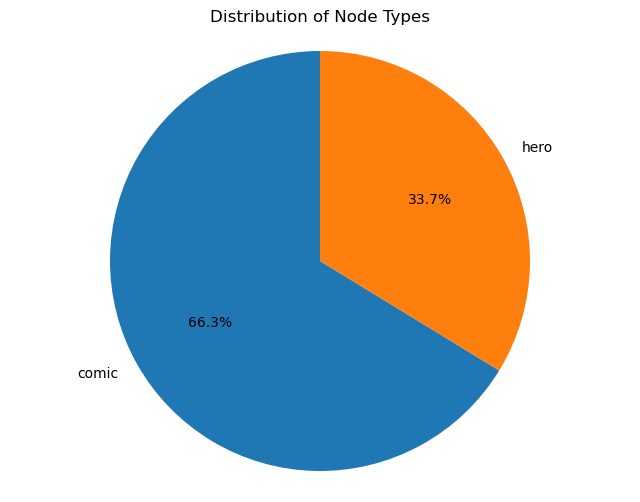

In [9]:
print(f"Number of nodes: {len(nodes_df)}")
print(f"Number of hero-comic connections: {len(edges_df)}")
print(f"Number of hero-hero connections: {len(hero_network_df)}")

# Count the node types
node_type_counts = nodes_df['type'].value_counts()
print("\nNode type distribution:")
print(node_type_counts)

# Create a pie chart for node types
plt.figure(figsize=(8, 6))
plt.pie(node_type_counts, labels=node_type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Node Types')
plt.axis('equal')
plt.show()

### 3.2.3. Isolated heroes

This code processes data about nodes and hero relationships. It first creates mappings between node names and numerical indices, and also assigns each node its type (e.g. hero or comic). It then filters the dataset to focus only on heroes, creating a hero-only subnetwork by selecting hero nodes and filtering the hero network edges accordingly. Finally, it performs basic data checks to identify any missing values and compares the number of unique heroes in the hero-hero network to those listed in the node dataset.

In [22]:
# Create mapping dictionaries for node names to indices
unique_nodes = nodes_df['node'].unique()
node_to_idx = {node: idx for idx, node in enumerate(unique_nodes)}
idx_to_node = {idx: node for node, idx in node_to_idx.items()}

# Map node types
node_types = {node: typ for node, typ in zip(nodes_df['node'], nodes_df['type'])}

# Create a hero-only graph
hero_nodes = nodes_df[nodes_df['type'] == 'hero']['node'].unique()
hero_to_idx = {hero: idx for idx, hero in enumerate(hero_nodes)}
# print(hero_to_idx)
idx_to_hero = {idx: hero for hero, idx in hero_to_idx.items()}
# print(idx_to_hero)

# Filter hero network to include only heroes in our node dataset
hero_network_filtered = hero_network_df[
    hero_network_df['hero1'].isin(hero_nodes) &
    hero_network_df['hero2'].isin(hero_nodes)
]

# Check for missing or duplicate data
print("\nChecking for missing values in nodes dataframe:")
print(nodes_df.isnull().sum())

print("\nChecking for missing values in edges dataframe:")
print(edges_df.isnull().sum())

print("\nChecking for missing values in hero network dataframe:")
print(hero_network_df.isnull().sum())

nb_hero_hero = len(set(hero_network_df['hero1'].unique()) | set(hero_network_df['hero2'].unique()))
print("\nNumber of unique heroes in the hero-hero network:", nb_hero_hero)

nb_hero_nodes = len(hero_nodes)
print("Number of unique heroes in the node list:", nb_hero_nodes)



Checking for missing values in nodes dataframe:
node    0
type    0
dtype: int64

Checking for missing values in edges dataframe:
hero     0
comic    0
dtype: int64

Checking for missing values in hero network dataframe:
hero1    0
hero2    0
dtype: int64

Number of unique heroes in the hero-hero network: 6418
Number of unique heroes in the node list: 6437


In [23]:
print("Difference of number of heroes between the node list and the hero-hero network:", nb_hero_nodes - nb_hero_hero)


Difference of number of heroes between the node list and the hero-hero network: 19


When we look a the difference in the number of unique heroes in the node list vs the hero-hero network, we can see that there are 19 more heroes in the node list, which suggests that some heroes are isolated, thus don't have any co-appearance with other heroes. 

We will now find out who are those isolated heroes. 

In [19]:
# Find heroes that are isolated (present in nodes but not in hero network)

# Get all heroes from nodes_df
hero_nodes = nodes_df[nodes_df['type'] == 'hero']['node'].unique()
print(f"Total number of heroes in nodes dataframe: {len(hero_nodes)}")

# Get all heroes from hero network
network_heroes = set(hero_network_df['hero1'].unique()) | set(hero_network_df['hero2'].unique())
print(f"Total number of heroes in hero network: {len(network_heroes)}")

# Find heroes that are in nodes_df but not in hero_network_df
isolated_heroes = set(hero_nodes) - network_heroes
print(f"Number of isolated heroes (in nodes but not in hero network): {len(isolated_heroes)}")

# Display some of these isolated heroes
if len(isolated_heroes) > 0:
    print("\nSample of isolated heroes (first 20):")
    for i, hero in enumerate(list(isolated_heroes)[:20]):
        print(f"{i+1}. {hero}")
    
    # Save isolated heroes to a CSV file
    import pandas as pd
    isolated_df = pd.DataFrame({'isolated_hero': list(isolated_heroes)})
    isolated_df.to_csv('Data/isolated_heroes.csv', index=False)
    print(f"\nAll {len(isolated_heroes)} isolated heroes saved to 'Data/isolated_heroes.csv'")
    
    # Let's also check if these heroes appear in the edges dataframe (hero-comic connections)
    if 'edges_df' in globals():
        heroes_in_edges = set(edges_df['hero'].unique())
        isolated_in_edges = isolated_heroes.intersection(heroes_in_edges)
        print(f"\nOf the isolated heroes, {len(isolated_in_edges)} appear in the edges dataframe")
        print("This means they appear in comics but don't have connections to other heroes")
        
        truly_isolated = isolated_heroes - heroes_in_edges
        print(f"\nTruly isolated heroes (not in hero network OR edges): {len(truly_isolated)}")
        if len(truly_isolated) > 0:
            print("Sample of truly isolated heroes (first 10):")
            for i, hero in enumerate(list(truly_isolated)[:10]):
                print(f"{i+1}. {hero}")
else:
    print("No isolated heroes found - all heroes in the nodes dataframe have connections in the hero network")

# We can also check for the opposite: heroes in the network but not in the nodes dataframe
missing_from_nodes = network_heroes - set(hero_nodes)
print(f"\nNumber of heroes in network but missing from nodes dataframe: {len(missing_from_nodes)}")
if len(missing_from_nodes) > 0:
    print("Sample of heroes missing from nodes (first 10):")
    for i, hero in enumerate(list(missing_from_nodes)[:10]):
        print(f"{i+1}. {hero}")

Total number of heroes in nodes dataframe: 6437
Total number of heroes in hero network: 6418
Number of isolated heroes (in nodes but not in hero network): 19

Sample of isolated heroes (first 20):
1. DEATHCHARGE
2. GERVASE, LADY ALYSSA
3. FENRIS
4. SHARKSKIN
5. CLUMSY FOULUP
6. JOHNSON, LYNDON BAIN
7. BLARE/
8. SEA LEOPARD
9. KULL
10. CALLAHAN, DANNY
11. RED WOLF II
12. SABRE/
13. BERSERKER II
14. GIURESCU, RADU
15. ZANTOR
16. RUNE
17. RANDAK
18. MARVEL BOY II/MARTIN
19. LUNATIK II

All 19 isolated heroes saved to 'Data/isolated_heroes.csv'

Of the isolated heroes, 19 appear in the edges dataframe
This means they appear in comics but don't have connections to other heroes

Truly isolated heroes (not in hero network OR edges): 0

Number of heroes in network but missing from nodes dataframe: 0


# 4. Network Analysis

## 4.1. Hero-hero network

In [ ]:
hero_nodes = nodes_df[nodes_df['type'] == 'hero']['node'].unique()
hero_network_filtered = hero_network_df[
    hero_network_df['hero1'].isin(hero_nodes) &
    hero_network_df['hero2'].isin(hero_nodes)
]

# Create a NetworkX graph for the hero-hero network
G_hero = nx.Graph()

# Add hero nodes
for hero in hero_nodes:
    G_hero.add_node(hero, type='hero')

# Add edges from the hero-hero network
for _, row in hero_network_filtered.iterrows():
    G_hero.add_edge(row['hero1'], row['hero2'])


### 4.1.1 Basic Descriptive statistics

In [26]:
# Basic network statistics
print("\nHero-Hero Network Stats:")
print(f"Number of nodes: {G_hero.number_of_nodes()}")
print(f"Number of edges: {G_hero.number_of_edges()}")



Hero-Hero Network Stats:
Number of nodes: 6437
Number of edges: 167007


### 4.1.2 Centrality measures


Top 20 heroes by degree centrality:


,Node,Degree,Betweenness,Closeness
857,CAPTAIN AMERICA,0.295836,0.051953,0.581874
5297,SPIDER-MAN/PETER PARKER,0.269733,0.068561,0.572450
2654,IRON MAN/TONY STARK,0.236327,0.034780,0.559808
5701,THING/BENJAMIN J. GR,0.219702,0.026235,0.556137
3797,MR. FANTASTIC/REED R,0.213797,0.023777,0.554345
6292,WOLVERINE/LOGAN,0.212244,0.036932,0.553140
2547,HUMAN TORCH/JOHNNY S,0.211156,0.025938,0.553236
4884,SCARLET WITCH/WANDA,0.205252,0.013825,0.550555
5720,THOR/DR. DONALD BLAK,0.200280,0.019809,0.549319
405,BEAST/HENRY &HANK& P,0.196240,0.020190,0.547428


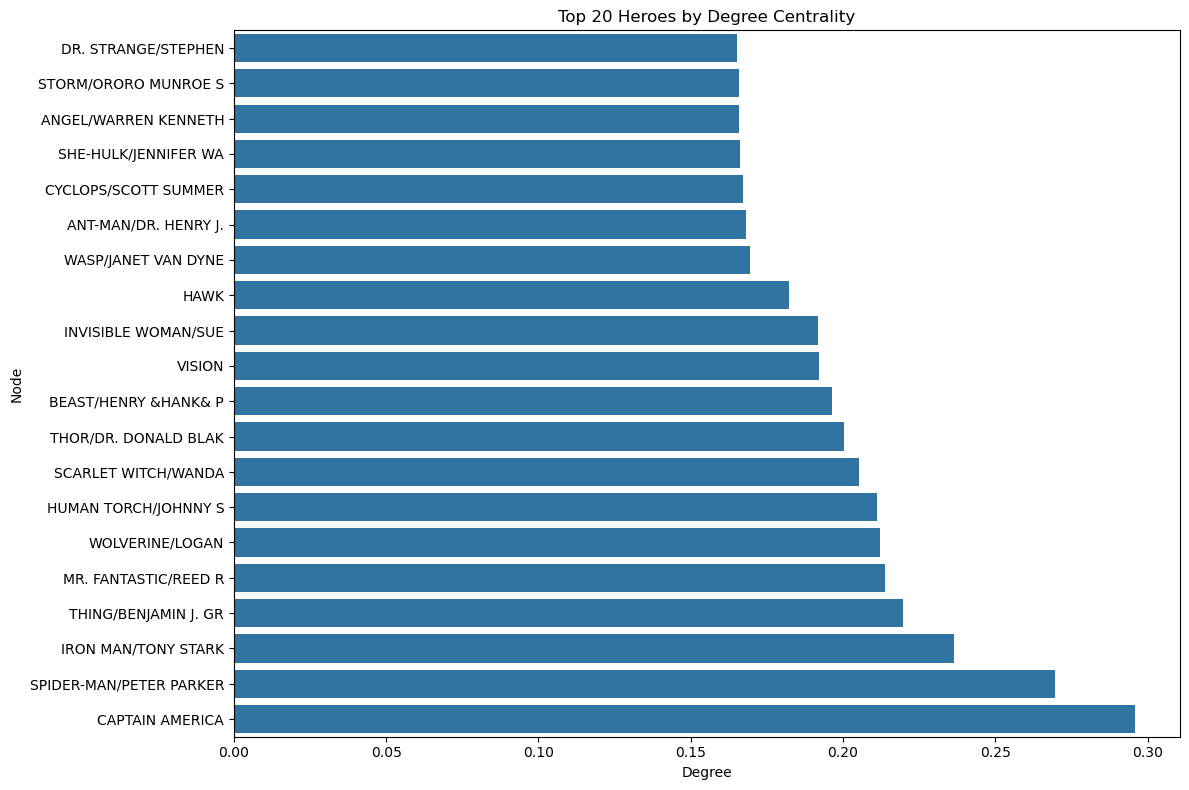

In [58]:
# Compute basic centrality measures for the hero network
def compute_centrality_measures(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, k=100)  # Using k for approximation in large networks
    closeness_centrality = nx.closeness_centrality(G)

    # Create a dataframe with the centrality measures
    centrality_df = pd.DataFrame({
        'Node': list(G.nodes()),
        'Degree': [degree_centrality[node] for node in G.nodes()],
        'Betweenness': [betweenness_centrality[node] for node in G.nodes()],
        'Closeness': [closeness_centrality[node] for node in G.nodes()]
    })

    return centrality_df

# Compute centrality measures for the hero network
hero_centrality = compute_centrality_measures(G_hero)

# Sort by degree centrality to find the most central heroes
top_heroes = hero_centrality.sort_values('Degree', ascending=False).head(20)
print("\nTop 20 heroes by degree centrality:")
display(top_heroes)

# Visualize top heroes by degree centrality
plt.figure(figsize=(12, 8))
sns.barplot(x='Degree', y='Node', data=top_heroes.sort_values('Degree'))
plt.title('Top 20 Heroes by Degree Centrality')
plt.tight_layout()
plt.show()

### 4.1.3 Network Density

In [28]:
# Network density calculation
density = nx.density(G_hero)
print(f"Network density: {density:.6f}")


Network density: 0.008062


This is a very sparse network - heroes are connected to very few other heroes relative to the possible connections.

### 4.1.4 Community detection

Hero network: 6437 nodes and 167007 edges
Number of connected components: 23
Largest component size: 6400 heroes
Using giant component with 6400 nodes for community detection

1. Running Louvain community detection...
Louvain detected 19 communities
Top 10 Louvain communities by size:
1. Community size: 1324 heroes
2. Community size: 1078 heroes
3. Community size: 1050 heroes
4. Community size: 909 heroes
5. Community size: 828 heroes
6. Community size: 371 heroes
7. Community size: 276 heroes
8. Community size: 167 heroes
9. Community size: 119 heroes
10. Community size: 117 heroes
Louvain modularity score: 0.4179


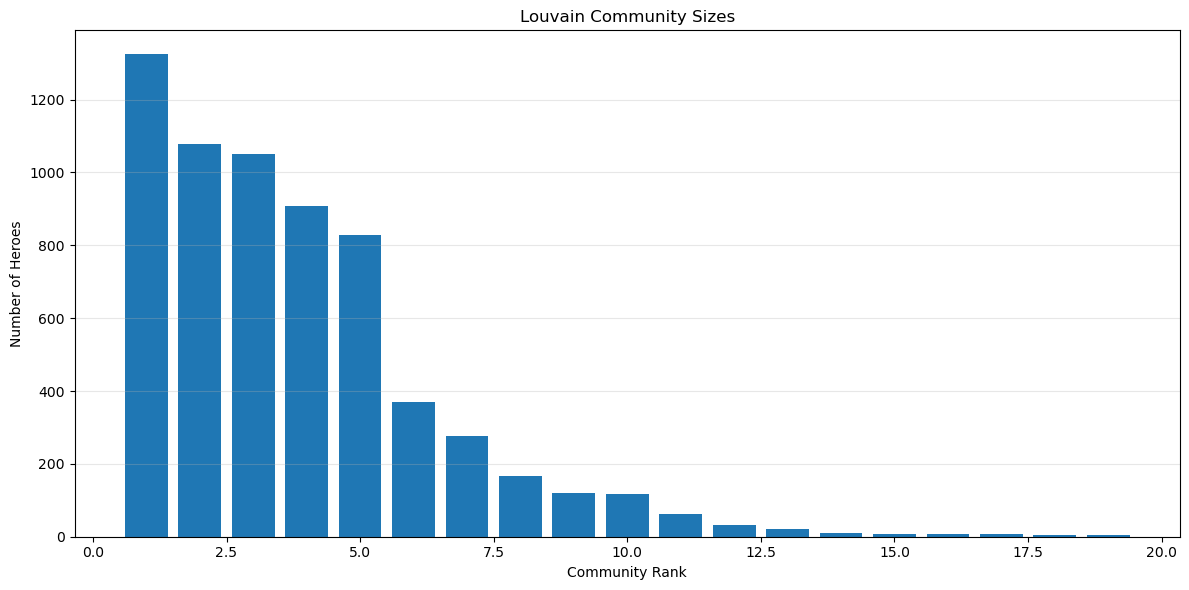


2. Running Label Propagation community detection...
Label Propagation detected 77 communities
Top 10 Label Propagation communities by size:
1. Community size: 5653 heroes
2. Community size: 117 heroes
3. Community size: 45 heroes
4. Community size: 34 heroes
5. Community size: 31 heroes
6. Community size: 30 heroes
7. Community size: 30 heroes
8. Community size: 25 heroes
9. Community size: 24 heroes
10. Community size: 23 heroes


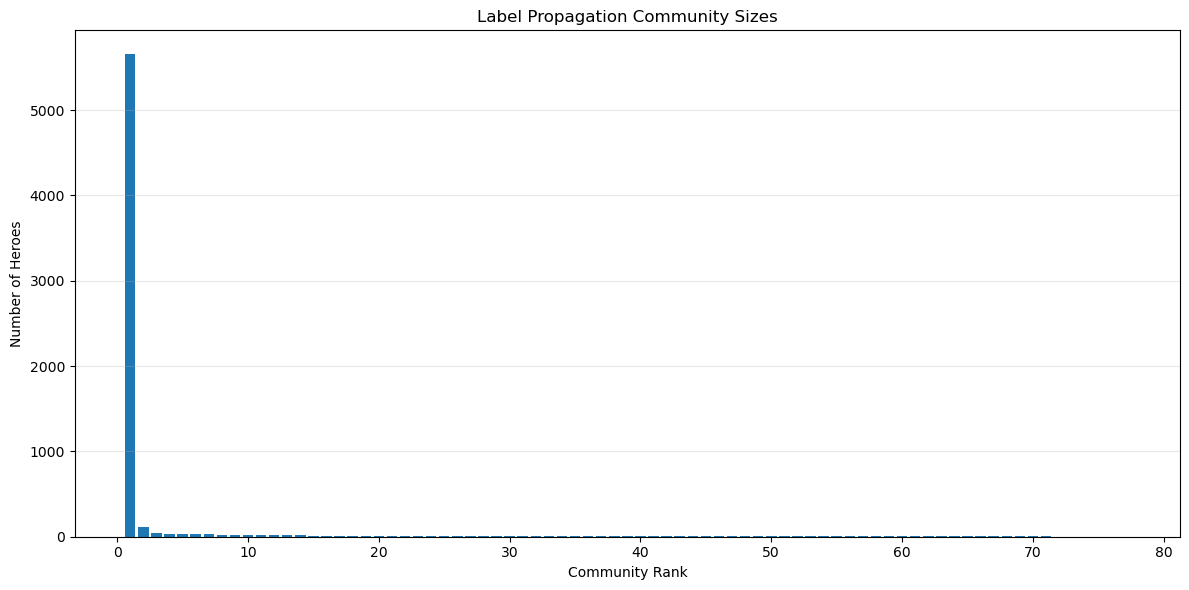

In [70]:
print(f"Hero network: {G_hero.number_of_nodes()} nodes and {G_hero.number_of_edges()} edges")

# First, find connected components
components = list(nx.connected_components(G_hero))
components.sort(key=len, reverse=True)
print(f"Number of connected components: {len(components)}")
print(f"Largest component size: {len(components[0])} heroes")

# We'll focus on the giant component for community detection
if len(components[0]) < G_hero.number_of_nodes():
    giant_component = G_hero.subgraph(components[0])
    print(f"Using giant component with {giant_component.number_of_nodes()} nodes for community detection")
else:
    giant_component = G_hero
    print("The graph is fully connected. Using the entire graph for community detection.")

# Method 1: Louvain Community Detection using NetworkX implementation
try:
    print("\n1. Running Louvain community detection...")
    
    # Use NetworkX's Louvain implementation
    louvain_communities = nx.community.louvain_communities(giant_component)
    louvain_communities = list(louvain_communities)  # Convert to list of sets
    
    print(f"Louvain detected {len(louvain_communities)} communities")
    
    # Sort communities by size
    louvain_communities.sort(key=len, reverse=True)
    
    print("Top 10 Louvain communities by size:")
    for i, community in enumerate(louvain_communities[:10], 1):
        print(f"{i}. Community size: {len(community)} heroes")
    
    # Create a partition dictionary for visualization and further analysis
    louvain_partition = {}
    for i, community in enumerate(louvain_communities):
        for node in community:
            louvain_partition[node] = i
    
    # Calculate modularity
    modularity = nx.community.modularity(giant_component, louvain_communities)
    print(f"Louvain modularity score: {modularity:.4f}")
    
    # Visualize community sizes
    plt.figure(figsize=(12, 6))
    community_sizes = [len(comm) for comm in louvain_communities]
    plt.bar(range(1, len(community_sizes) + 1), community_sizes)
    plt.xlabel('Community Rank')
    plt.ylabel('Number of Heroes')
    plt.title('Louvain Community Sizes')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    
except Exception as e:
    print(f"Error running Louvain community detection: {e}")
    print("This might be due to an older version of NetworkX. Try updating or use another method.")

# Method 2: Label Propagation
try:
    print("\n2. Running Label Propagation community detection...")
    lpa_communities = nx.algorithms.community.label_propagation_communities(giant_component)
    lpa_communities = list(lpa_communities)
    print(f"Label Propagation detected {len(lpa_communities)} communities")
    
    # Sort communities by size
    lpa_communities.sort(key=len, reverse=True)
    
    print("Top 10 Label Propagation communities by size:")
    for i, community in enumerate(lpa_communities[:10], 1):
        print(f"{i}. Community size: {len(community)} heroes")
    
    # Visualize community sizes
    plt.figure(figsize=(12, 6))
    community_sizes = [len(comm) for comm in lpa_communities]
    plt.bar(range(1, len(community_sizes) + 1), community_sizes)
    plt.xlabel('Community Rank')
    plt.ylabel('Number of Heroes')
    plt.title('Label Propagation Community Sizes')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    
except Exception as e:
    print(f"Error running Label Propagation: {e}")


### 4.1.5. Average Path Length

In [31]:
# Get the connected components
components = list(nx.connected_components(G_hero))
num_components = len(components)
print(f"Number of connected components: {num_components}")

# Get the sizes of the components
component_sizes = [len(c) for c in components]
largest_component_size = max(component_sizes)
print(f"Size of largest connected component: {largest_component_size}")
print(f"Percentage of heroes in largest component: {largest_component_size / G_hero.number_of_nodes() * 100:.2f}%")

if num_components > 1:
    print(f"Sizes of next 5 largest components: {sorted(component_sizes, reverse=True)[1:6]}")

# Extract the largest connected component for path length analysis
largest_cc = G_hero.subgraph(components[component_sizes.index(largest_component_size)])
print(f"\nAnalyzing largest connected component with {largest_cc.number_of_nodes()} nodes and {largest_cc.number_of_edges()} edges")

# Calculate the average shortest path length for the largest component
avg_path_length = nx.average_shortest_path_length(largest_cc)
print(f"Average shortest path length: {avg_path_length:.4f}")

# Calculate the diameter (longest shortest path)
# diameter = nx.diameter(largest_cc)
# print(f"Network diameter (longest shortest path): {diameter}")

# Calculate the radius
# radius = nx.radius(largest_cc)
# print(f"Network radius: {radius}")

print("- Random networks with same size and density would have path lengths of approximately ln(n)/ln(k)")
print(f"  where n={largest_cc.number_of_nodes()} and k=average degree ~{2*largest_cc.number_of_edges()/largest_cc.number_of_nodes():.2f}")

Number of connected components: 23
Size of largest connected component: 6400
Percentage of heroes in largest component: 99.43%
Sizes of next 5 largest components: [9, 7, 2, 1, 1]

Analyzing largest connected component with 6400 nodes and 166951 edges


KeyboardInterrupt: 

This is a very compact network with an average of only 2.64 steps between any two heroes. This suggests a 'small world' property - any hero can reach any other through just a few connections.

### 4.1.6 Degree Distribution

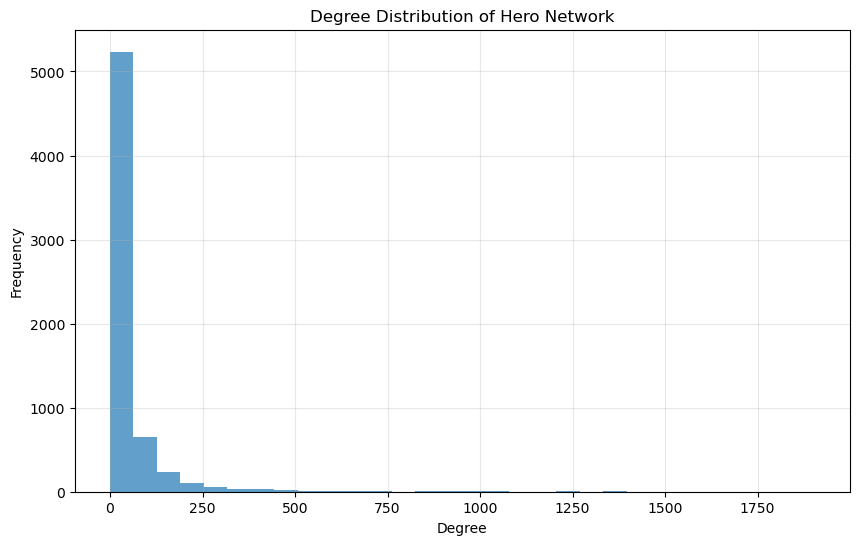

In [33]:

# Plot degree distribution
degrees = [d for n, d in G_hero.degree()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=30, alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Hero Network')
plt.grid(True, alpha=0.3)
plt.show()

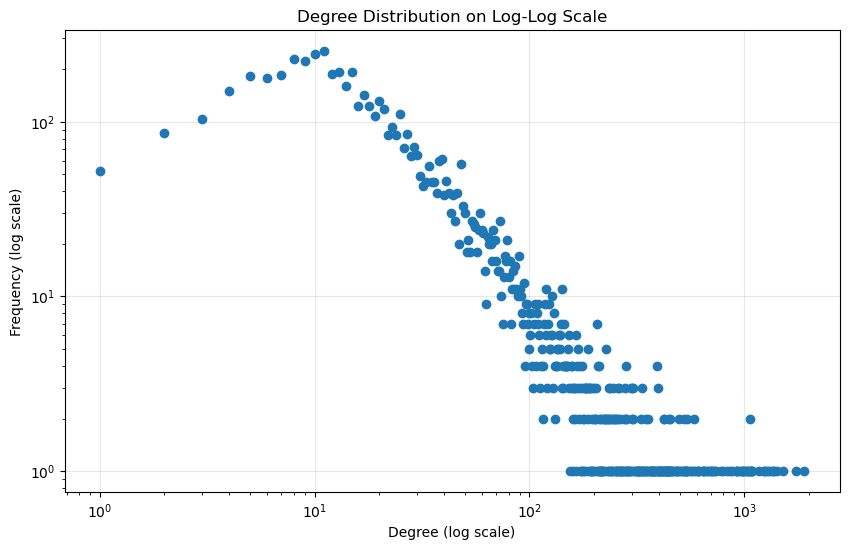

In [34]:
# Plot degree distribution on log-log scale to check for power law
degree_counts = pd.Series(degrees).value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.loglog(degree_counts.index, degree_counts.values, 'o')
plt.xlabel('Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Degree Distribution on Log-Log Scale')
plt.grid(True, alpha=0.3)
plt.show()

## 4.2. Hero-comic bipartite network 

Since the hero-comic network is not a usual network, we will do different analysis than the ones we did for the hero-hero network: 
- 4.2.1 Basic Descriptive analysis
- 4.2.2 Degree Distribution
- 4.2.3 Bipartite Projections (hero to comic and comic to hero)
    - 4.2.3.1 Clustering coefficient
    - 4.2.3.2 Centrality Measures
    - 4.2.3.3 Communities
- 4.2.4 Component Analysis
- 4.2.5 Bipartite clustering coefficient
- 4.2.6 Assortativity

In [35]:
# Create a NetworkX graph for the bipartite hero-comic network
G_bipartite = nx.Graph()

# Add all nodes
for _, row in nodes_df.iterrows():
    G_bipartite.add_node(row['node'], type=row['type'])

# Add edges from the hero-comic connections
for _, row in edges_df.iterrows():
    G_bipartite.add_edge(row['hero'], row['comic'])

In [ ]:
# First, check if all nodes have the 'type' attribute
nodes_with_type = sum(1 for _, attr in G_bipartite.nodes(data=True) if 'type' in attr)
print(f"Nodes with 'type' attribute: {nodes_with_type}/{G_bipartite.number_of_nodes()}")

if nodes_with_type < G_bipartite.number_of_nodes():
    print("WARNING: Some nodes don't have 'type' attribute. Fixing this issue...")
    
    # Option 1: Try to infer node types based on the bipartite structure
    # This assumes heroes only connect to comics and vice versa
    
    # First identify all heroes and comics from nodes_df
    known_heroes = set(row['node'] for _, row in nodes_df.iterrows() 
                      if row['type'] == 'hero')
    known_comics = set(row['node'] for _, row in nodes_df.iterrows() 
                      if row['type'] == 'comic')
    
    # Get all nodes from the graph
    all_nodes = set(G_bipartite.nodes())
    
    # Find nodes without type attributes
    untyped_nodes = all_nodes - known_heroes - known_comics
    print(f"Found {len(untyped_nodes)} nodes without type information")
    
    # For nodes in edges_df but not in nodes_df, try to infer their type
    for node in untyped_nodes:
        # Check if it connects to any known hero
        connects_to_hero = any(neighbor in known_heroes 
                              for neighbor in G_bipartite.neighbors(node))
        # Check if it connects to any known comic
        connects_to_comic = any(neighbor in known_comics 
                               for neighbor in G_bipartite.neighbors(node))
        
        if connects_to_hero and not connects_to_comic:
            # If it only connects to heroes, it must be a comic
            G_bipartite.nodes[node]['type'] = 'comic'
        elif connects_to_comic and not connects_to_hero:
            # If it only connects to comics, it must be a hero
            G_bipartite.nodes[node]['type'] = 'hero'
        else:
            # If we can't infer, default to 'unknown'
            G_bipartite.nodes[node]['type'] = 'unknown'
    
    # Check again
    nodes_with_type = sum(1 for _, attr in G_bipartite.nodes(data=True) if 'type' in attr)
    print(f"After fixing: Nodes with 'type' attribute: {nodes_with_type}/{G_bipartite.number_of_nodes()}")


Nodes with 'type' attribute: 19088/19091
Found 3 nodes without type information
After fixing: Nodes with 'type' attribute: 19091/19091


### 4.2.1 Basic descriptive statistics

In [39]:
print("\nBipartite Hero-Comic Network Stats:")
print(f"Number of nodes: {G_bipartite.number_of_nodes()}")
print(f"Number of edges: {G_bipartite.number_of_edges()}")
print(f"Network density: {nx.density(G_bipartite):.6f}")


Bipartite Hero-Comic Network Stats:
Number of nodes: 19091
Number of edges: 96104
Network density: 0.000527


### 4.2.2 Degree Distribution

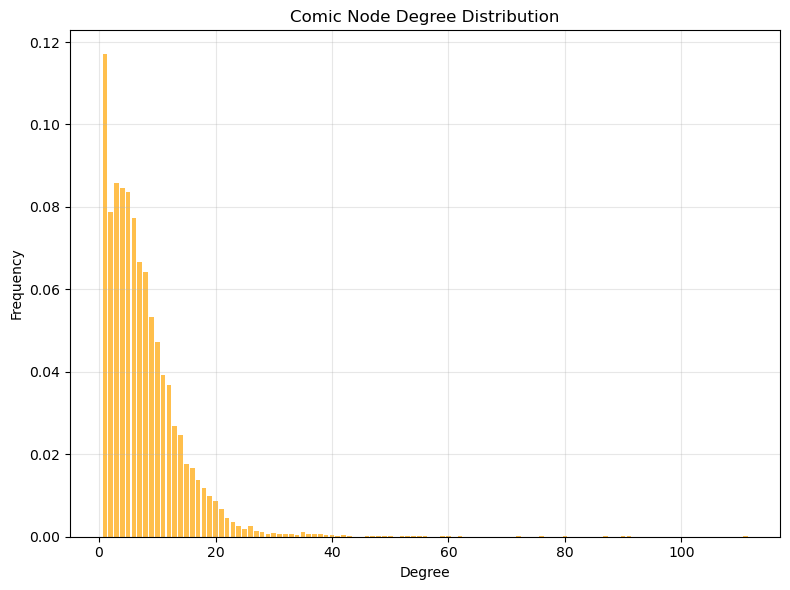

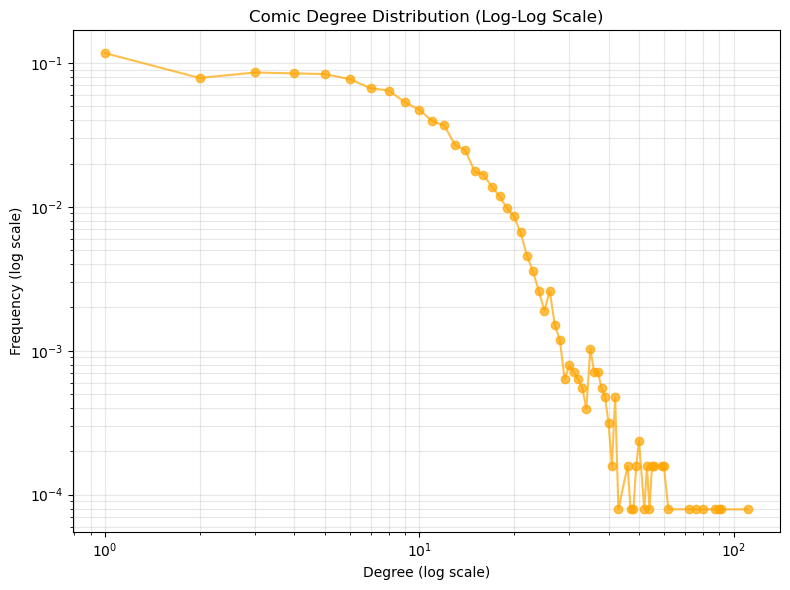


Comic degree statistics:
  min_degree: 1
  max_degree: 111
  mean_degree: 7.596553632123943
  median_degree: 6.0


In [59]:
# Get degrees for different node types
comic_nodes = [node for node, attr in G_bipartite.nodes(data=True) if attr['type'] == 'comic']

# Calculate degrees
comic_degrees = [G_bipartite.degree(node) for node in comic_nodes]

# Create degree distributions
comic_degree_dist = Counter(comic_degrees)

# Convert to DataFrames for easier plotting
comic_df = pd.DataFrame({
    'Degree': list(comic_degree_dist.keys()),
    'Count': list(comic_degree_dist.values())
})
comic_df['Frequency'] = comic_df['Count'] / comic_df['Count'].sum()
comic_df = comic_df.sort_values('Degree')

# Create a figure with two subplots
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 6))

# Plot comic degree distribution
ax2.bar(comic_df['Degree'], comic_df['Frequency'], alpha=0.7, color='orange')
ax2.set_xlabel('Degree')
ax2.set_ylabel('Frequency')
ax2.set_title('Comic Node Degree Distribution')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Check for power law distribution (log-log plot)
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 6))

# Comic log-log plot
comic_df_nonzero = comic_df[comic_df['Count'] > 0]  # Avoid log(0)
ax2.loglog(comic_df_nonzero['Degree'], comic_df_nonzero['Frequency'], 'o-', alpha=0.7, color='orange')
ax2.set_xlabel('Degree (log scale)')
ax2.set_ylabel('Frequency (log scale)')
ax2.set_title('Comic Degree Distribution (Log-Log Scale)')
ax2.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

comic_stats = {
    'min_degree': min(comic_degrees),
    'max_degree': max(comic_degrees),
    'mean_degree': np.mean(comic_degrees),
    'median_degree': np.median(comic_degrees)
}

print("\nComic degree statistics:")
for stat, value in comic_stats.items():
    print(f"  {stat}: {value}")

**Fit power law to degree distribution**

In [60]:
def fit_power_law(degrees, node_type):
    # Use only degrees > 0 for log fitting
    degrees_for_fit = [d for d in degrees if d > 0]
    if len(degrees_for_fit) > 1:
        log_degrees = np.log(degrees_for_fit)
        log_freqs = np.log([hero_degree_dist[d] / len(hero_degrees) 
                           if node_type == 'hero' else 
                           comic_degree_dist[d] / len(comic_degrees) 
                           for d in degrees_for_fit])
        
        # Linear regression on log-log data
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_degrees, log_freqs)
        
        print(f"\n{node_type.capitalize()} power law fit:")
        print(f"  Exponent (slope): {slope:.4f}")
        print(f"  R-squared: {r_value**2:.4f}")
        print(f"  p-value: {p_value:.4e}")
        
        return slope, intercept, r_value**2
    else:
        print(f"\nNot enough data points to fit power law for {node_type}s")
        return None, None, None

# Fit power laws
comic_power_law = fit_power_law(list(comic_degree_dist.keys()), 'comic')



Comic power law fit:
  Exponent (slope): -2.4184
  R-squared: 0.8563
  p-value: 2.2134e-27


### 4.2.3 Bipartite Projection of Comics

Now we create one projection of the bipartite graph: the comic projection where comics are connected if they share heroes. We don't create a hero projection, because this corresponds to the hero-hero network.

In [61]:
# Identify the node sets (heroes and comics)
comic_nodes = [node for node, attr in G_bipartite.nodes(data=True) 
              if attr.get('type', '') == 'comic']

print(f"Number of comics: {len(comic_nodes)}")

# Create comic projection (comics connected if they share heroes)
print("\nCreating comic projection graph (comic-comic)...")
G_comic_projection = nx.algorithms.bipartite.projected_graph(G_bipartite, comic_nodes)
print(f"Comic projection has {G_comic_projection.number_of_nodes()} nodes and {G_comic_projection.number_of_edges()} edges")


Number of comics: 12651

Creating comic projection graph (comic-comic)...
Comic projection has 12651 nodes and 7022085 edges


#### 4.2.3.1 Clustering coefficient

In [55]:
if G_comic_projection.number_of_edges() > 0:
    comic_clustering = nx.average_clustering(G_comic_projection)
    print(f"Comic projection average clustering coefficient: {comic_clustering:.4f}")
else:
    print("Comic projection has no edges, cannot calculate clustering")

KeyboardInterrupt: 

#### 4.2.3.2 Basic properties analysis


--- Comic Projection Analysis ---
Average degree: 1110.12
Min degree: 0
Max degree: 9665
Number of connected components: 22
Largest component size: 12626 comics
Percentage of comics in giant component: 99.80%


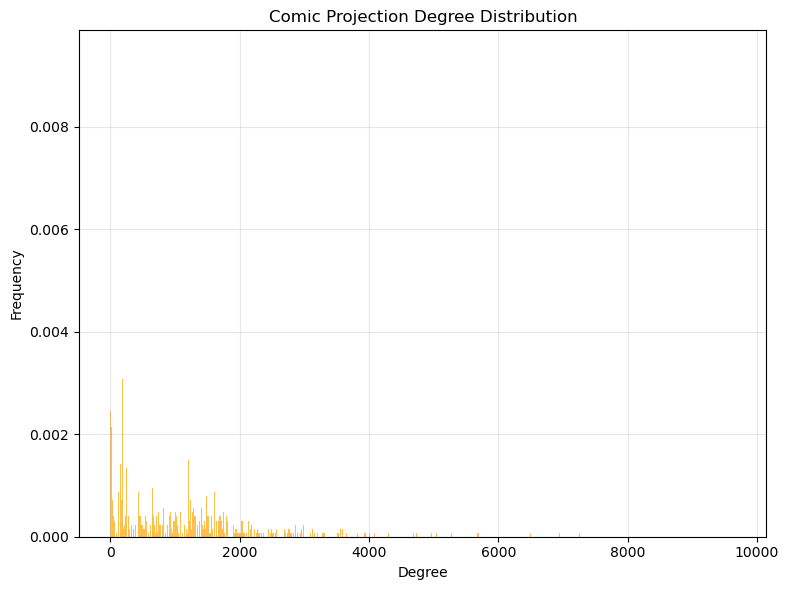

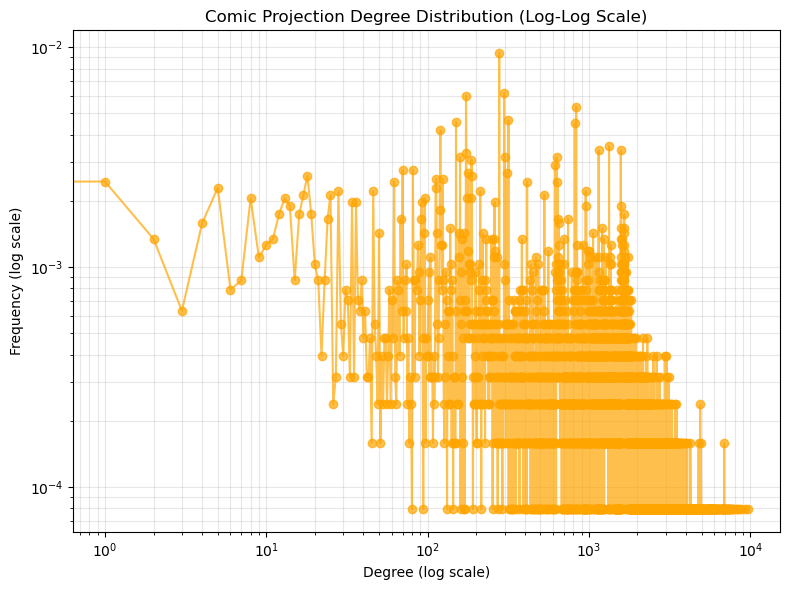

In [63]:
# Analyze basic properties of the projections
print("\n--- Comic Projection Analysis ---")
comic_degrees = [G_comic_projection.degree(node) for node in G_comic_projection.nodes()]
if comic_degrees:
    print(f"Average degree: {np.mean(comic_degrees):.2f}")
    print(f"Min degree: {min(comic_degrees)}")
    print(f"Max degree: {max(comic_degrees)}")
    
    # Analyze connected components
    comic_components = list(nx.connected_components(G_comic_projection))
    print(f"Number of connected components: {len(comic_components)}")
    comic_components.sort(key=len, reverse=True)
    if comic_components:
        print(f"Largest component size: {len(comic_components[0])} comics")
        giant_comic_pct = (len(comic_components[0]) / G_comic_projection.number_of_nodes()) * 100
        print(f"Percentage of comics in giant component: {giant_comic_pct:.2f}%")

# Visualize degree distributions
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 6))

if comic_degrees:
    comic_degree_count = Counter(comic_degrees)
    comic_degree_dist = pd.DataFrame({
        'Degree': list(comic_degree_count.keys()),
        'Count': list(comic_degree_count.values())
    })
    comic_degree_dist['Frequency'] = comic_degree_dist['Count'] / sum(comic_degree_dist['Count'])
    comic_degree_dist = comic_degree_dist.sort_values('Degree')
    
    ax2.bar(comic_degree_dist['Degree'], comic_degree_dist['Frequency'], alpha=0.7, color='orange')
    ax2.set_xlabel('Degree')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Comic Projection Degree Distribution')
    ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Create log-log plots to check for power-law distributions
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 6))

# Comic projection log-log plot
if comic_degrees and len(comic_degree_dist) > 0:
    comic_degree_dist_nonzero = comic_degree_dist[comic_degree_dist['Count'] > 0]
    if not comic_degree_dist_nonzero.empty:
        ax2.loglog(comic_degree_dist_nonzero['Degree'], comic_degree_dist_nonzero['Frequency'], 'o-', alpha=0.7, color='orange')
        ax2.set_xlabel('Degree (log scale)')
        ax2.set_ylabel('Frequency (log scale)')
        ax2.set_title('Comic Projection Degree Distribution (Log-Log Scale)')
        ax2.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()


#### 4.2.3.3 Communities

Comic projection graph: 12651 nodes and 7022085 edges
Number of connected components: 22
Largest component size: 12626 comics
Using giant component with 12626 nodes for community detection

1. Running Louvain community detection...
Louvain detected 11 communities
Top 10 Louvain communities by size:
1. Community size: 3377 heroes
2. Community size: 2429 heroes
3. Community size: 1770 heroes
4. Community size: 1725 heroes
5. Community size: 1576 heroes
6. Community size: 1393 heroes
7. Community size: 303 heroes
8. Community size: 19 heroes
9. Community size: 14 heroes
10. Community size: 10 heroes
Louvain modularity score: 0.4624


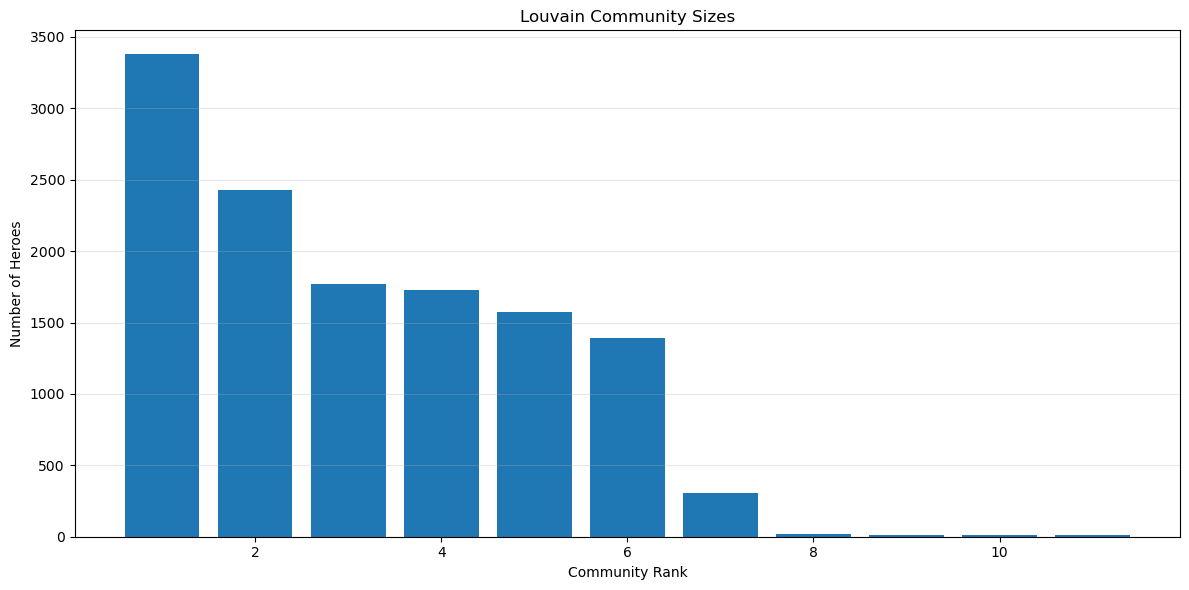


2. Running Label Propagation community detection...
Label Propagation detected 18 communities
Top 10 Label Propagation communities by size:
1. Community size: 12310 comics
2. Community size: 142 comics
3. Community size: 27 comics
4. Community size: 22 comics
5. Community size: 19 comics
6. Community size: 14 comics
7. Community size: 14 comics
8. Community size: 13 comics
9. Community size: 11 comics
10. Community size: 10 comics


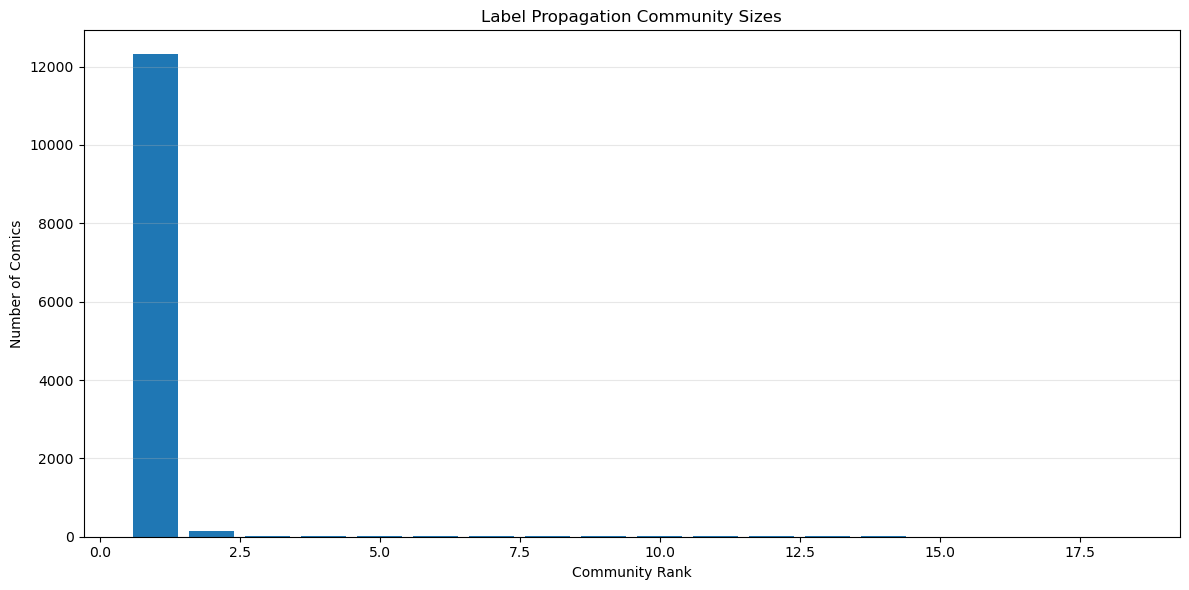

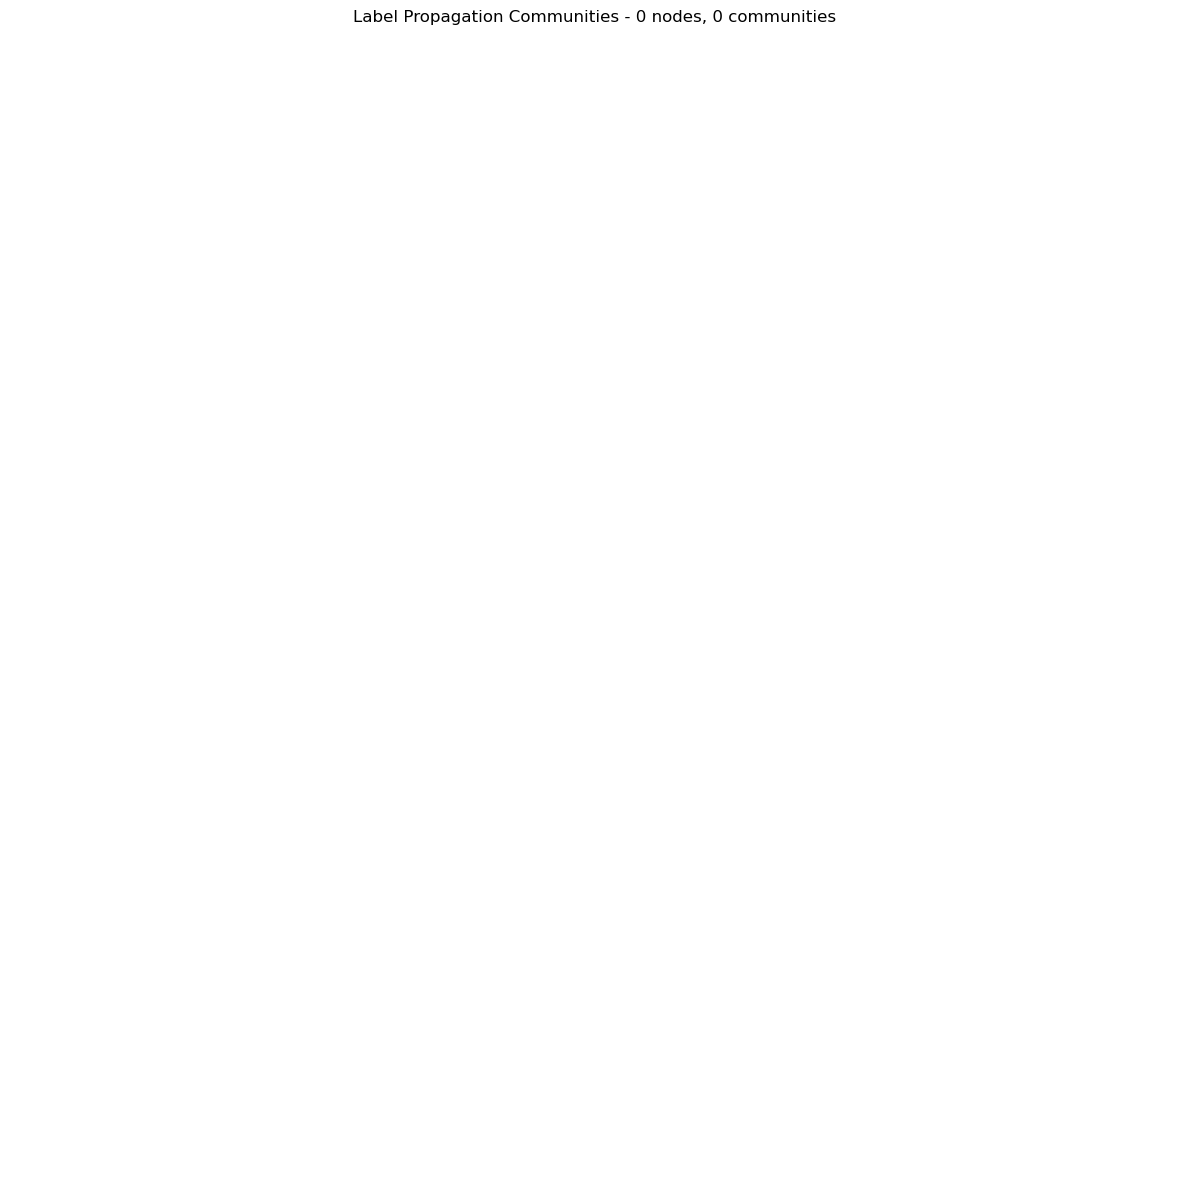


Analyzing hero composition of comic communities...
Error in hero composition analysis: 'list' object has no attribute 'items'


In [ ]:
print(f"Comic projection graph: {G_comic_projection.number_of_nodes()} nodes and {G_comic_projection.number_of_edges()} edges")

# First, find connected components
components = list(nx.connected_components(G_comic_projection))
components.sort(key=len, reverse=True)
print(f"Number of connected components: {len(components)}")
print(f"Largest component size: {len(components[0])} comics")

# We'll focus on the giant component for community detection
if len(components[0]) < G_comic_projection.number_of_nodes():
    giant_component = G_comic_projection.subgraph(components[0])
    print(f"Using giant component with {giant_component.number_of_nodes()} nodes for community detection")
else:
    giant_component = G_comic_projection
    print("The graph is fully connected. Using the entire graph for community detection.")

# Method 1: Louvain Community Detection using NetworkX implementation
try:
    print("\n1. Running Louvain community detection...")
    
    # Use NetworkX's Louvain implementation
    louvain_communities = nx.community.louvain_communities(giant_component)
    louvain_communities = list(louvain_communities)  # Convert to list of sets
    
    print(f"Louvain detected {len(louvain_communities)} communities")
    
    # Sort communities by size
    louvain_communities.sort(key=len, reverse=True)
    
    print("Top 10 Louvain communities by size:")
    for i, community in enumerate(louvain_communities[:10], 1):
        print(f"{i}. Community size: {len(community)} heroes")
    
    # Create a partition dictionary for visualization and further analysis
    louvain_partition = {}
    for i, community in enumerate(louvain_communities):
        for node in community:
            louvain_partition[node] = i
    
    # Calculate modularity
    modularity = nx.community.modularity(giant_component, louvain_communities)
    print(f"Louvain modularity score: {modularity:.4f}")
    
    # Visualize community sizes
    plt.figure(figsize=(12, 6))
    community_sizes = [len(comm) for comm in louvain_communities]
    plt.bar(range(1, len(community_sizes) + 1), community_sizes)
    plt.xlabel('Community Rank')
    plt.ylabel('Number of Heroes')
    plt.title('Louvain Community Sizes')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    
except Exception as e:
    print(f"Error running Louvain community detection: {e}")
    print("This might be due to an older version of NetworkX. Try updating or use another method.")

# Method 2: Label Propagation
try:
    print("\n2. Running Label Propagation community detection...")
    lpa_communities = nx.algorithms.community.label_propagation_communities(giant_component)
    lpa_communities = list(lpa_communities)
    print(f"Label Propagation detected {len(lpa_communities)} communities")
    
    # Sort communities by size
    lpa_communities.sort(key=len, reverse=True)
    
    print("Top 10 Label Propagation communities by size:")
    for i, community in enumerate(lpa_communities[:10], 1):
        print(f"{i}. Community size: {len(community)} comics")
    
    # Create a partition dict for visualization
    lpa_partition = {}
    for i, community in enumerate(lpa_communities):
        for node in community:
            lpa_partition[node] = i
    
    # Visualize community sizes
    plt.figure(figsize=(12, 6))
    community_sizes = [len(comm) for comm in lpa_communities]
    plt.bar(range(1, len(community_sizes) + 1), community_sizes)
    plt.xlabel('Community Rank')
    plt.ylabel('Number of Comics')
    plt.title('Label Propagation Community Sizes')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    
except Exception as e:
    print(f"Error running Label Propagation: {e}")


# Community Analysis - Hero Composition
# This analyzes which heroes appear in which comic communities
try:
    print("\nAnalyzing hero composition of comic communities...")
    
    # Use Louvain communities if available, otherwise use Label Propagation
    if 'louvain_communities' in locals():
        selected_communities = louvain_communities
        community_method = "Louvain"
    elif 'lpa_communities' in locals():
        selected_communities = {i: list(comm) for i, comm in enumerate(lpa_communities)}
        community_method = "Label Propagation"
    else:
        print("No community detection results available for hero composition analysis")
        raise Exception("Missing community detection results")
    
    # Analyze top communities
    top_communities = sorted([(comm_id, len(nodes)) for comm_id, nodes in selected_communities.items()], 
                            key=lambda x: x[1], reverse=True)[:5]  # Top 5 communities
    
    print(f"Analyzing hero composition for top {len(top_communities)} {community_method} communities...")
    
    for rank, (comm_id, size) in enumerate(top_communities, 1):
        comics = selected_communities[comm_id]
        
        # Find heroes that appear in these comics
        community_heroes = defaultdict(int)
        
        for comic in comics:
            # Get heroes connected to this comic in the original bipartite graph
            for hero in G_bipartite.neighbors(comic):
                if G_bipartite.nodes[hero].get('type', '') == 'hero':
                    community_heroes[hero] += 1
        
        # Sort heroes by frequency
        top_heroes = sorted(community_heroes.items(), key=lambda x: x[1], reverse=True)[:20]
        
        print(f"\nCommunity {rank} ({size} comics)")
        print("Top heroes in this community:")
        for i, (hero, count) in enumerate(top_heroes, 1):
            print(f"{i}. {hero}: appears in {count} comics ({count/size:.1%} of community)")
    
except Exception as e:
    print(f"Error in hero composition analysis: {e}")

### 4.2.4 Component Analysis

In [46]:
# Get connected components
components = list(nx.connected_components(G_bipartite))
print(f"Number of connected components: {len(components)}")

# Sort components by size (largest first)
components.sort(key=len, reverse=True)

# Analyze component sizes
component_sizes = [len(c) for c in components]
print(f"Largest component size: {component_sizes[0]} nodes")
print(f"Second largest component size: {component_sizes[1] if len(component_sizes) > 1 else 'N/A'} nodes")

# Calculate what percentage of nodes are in the largest component (giant component)
giant_component_percentage = (component_sizes[0] / G_bipartite.number_of_nodes()) * 100
print(f"Percentage of nodes in giant component: {giant_component_percentage:.2f}%")

# Analyze node types in the largest component
largest_component = components[0]
giant = G_bipartite.subgraph(largest_component)

# Count node types in giant component
giant_heroes = [node for node, attr in giant.nodes(data=True) 
                if attr.get('type', '') == 'hero']
giant_comics = [node for node, attr in giant.nodes(data=True) 
                if attr.get('type', '') == 'comic']

print(f"Heroes in giant component: {len(giant_heroes)}")
print(f"Comics in giant component: {len(giant_comics)}")


Number of connected components: 23
Largest component size: 19029 nodes
Second largest component size: 11 nodes
Percentage of nodes in giant component: 99.68%
Heroes in giant component: 6403
Comics in giant component: 12626



Hero-Comic Ratios in Top Components:
   component   size  heroes  comics  hero_ratio
0          1  19029    6403   12626    0.336486
1          2     11       9       2    0.818182
2          3      8       7       1    0.875000
3          4      4       2       2    0.500000
4          5      3       1       2    0.333333
5          6      3       1       2    0.333333
6          7      2       1       1    0.500000
7          8      2       1       1    0.500000
8          9      2       1       1    0.500000
9         10      2       1       1    0.500000


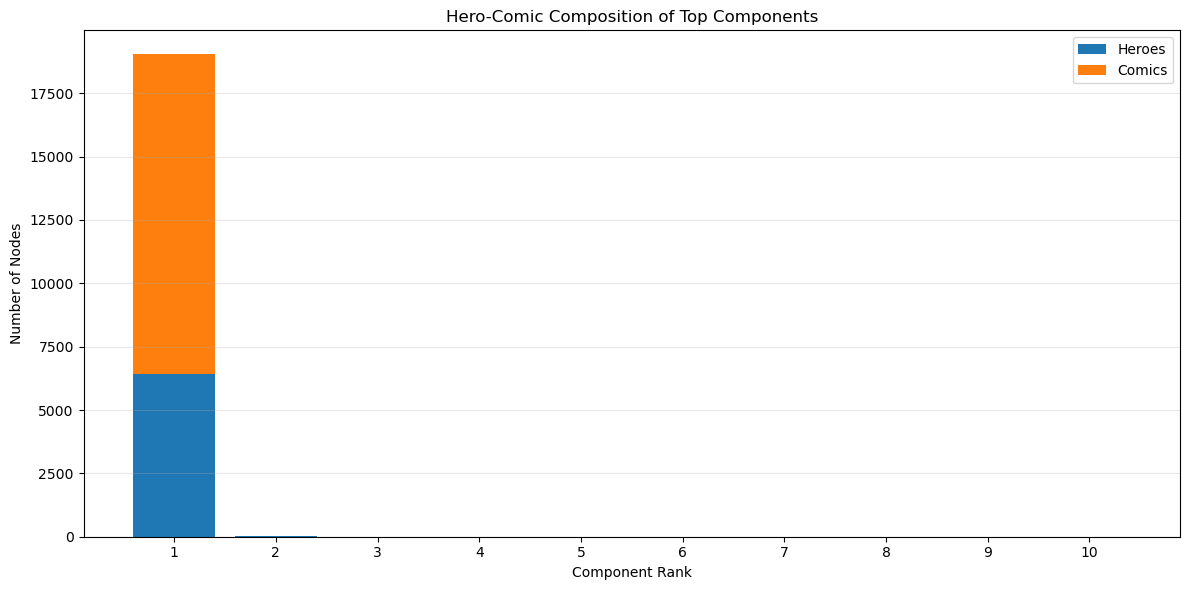

In [49]:
# Optional: Analyze hero-comic ratio across components
component_ratios = []
for i, comp in enumerate(components[:min(10, len(components))]):  # Analyze top 10 components
    subgraph = G_bipartite.subgraph(comp)
    heroes = len([node for node, attr in subgraph.nodes(data=True) if attr.get('type', '') == 'hero'])
    comics = len([node for node, attr in subgraph.nodes(data=True) if attr.get('type', '') == 'comic'])
    total = heroes + comics
    if total > 0:  # Avoid division by zero
        hero_ratio = heroes / total
        component_ratios.append({
            'component': i + 1,
            'size': total,
            'heroes': heroes,
            'comics': comics,
            'hero_ratio': hero_ratio
        })

# Display hero-comic ratio for top components
ratio_df = pd.DataFrame(component_ratios)
print("\nHero-Comic Ratios in Top Components:")
print(ratio_df)

# Visualize hero-comic composition of top components
if not ratio_df.empty:
    plt.figure(figsize=(12, 6))
    plt.bar(ratio_df['component'], ratio_df['heroes'], label='Heroes')
    plt.bar(ratio_df['component'], ratio_df['comics'], bottom=ratio_df['heroes'], label='Comics')
    plt.xlabel('Component Rank')
    plt.ylabel('Number of Nodes')
    plt.title('Hero-Comic Composition of Top Components')
    plt.legend()
    plt.xticks(ratio_df['component'])
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# 5. Network visualisation

## 5.1 Hero-hero network